In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "tutorial.gym.atari.spaceinvaders-v0.cnn"
snapshot_path = "."


#gym game title
GAME_TITLE = 'SpaceInvaders-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 10


#how long is one replay session from a batch

#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 20


In [40]:
#this is my machine-specific config. replace if are not me.

#theano device selection
%env THEANO_FLAGS='device=gpu'


#snapshot path - where neural network snapshots are saved during the main training loop
!mkdir ./agentnet_snapshots/
snapshot_path = "./agentnet_snapshots/"


env: THEANO_FLAGS='device=gpu'
mkdir: cannot create directory `./agentnet_snapshots/': File exists


# This tutorial is a showcase on how to use AgentNet for OpenAI Gym environments

* We take Space Invadets game as an example
* We train a simple-stupid convolutional network for Q_learning objective
* We do have a GPU for that, so if you don't, we have a "linear regression" mode - just uncomment it :)
* We train via experience replay using SessionPoolEnvironment, explained below
* We do NOT use recurrent layers for simplicity
* We do NOT use "smart" experience replay for simplicity
* We use simple stupid one-step q-learning.. you guessed it, for simplicity


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym
  
  
### Installing it
 * If nothing changed on their side, to run this, you bacically need to follow their install instructions - 
 
```
git clone https://github.com/openai/gym.git
cd gym
pip install -e .[all]
```

In [3]:
#Choose your side

#Sith
mode = "simple convnet"

#Jedi
#mode = "dense nn"

#Stormtrooper
#mode = "linear regression"


In [4]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports

import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN 4004)


In [5]:
%load_ext autoreload
%autoreload 2

# Experiment setup
* Here we basically just load the game

[2016-04-29 23:11:44,639] Making new env: SpaceInvaders-v0


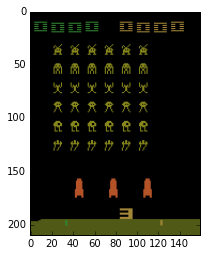

In [6]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

In [7]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print action_names

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [8]:
del atari

# agent setup
* An agent implementation may contain these parts:
 * Observation(s)
   * InputLayers where observed game states (here - images) are sent at each tick 
 * Memory layer(s)
   * A dictionary that maps "New memory layers" to "prev memory layers"
 * Policy layer (e.g. Q-values or probabilities)
   * in this case, a lasagne dense layer based on observation layer
 * Resolver - acton picker layer
   * in this case, the resolver has epsilon-greedy policy
  
  
### Simple no-memory model

Since we have almost fully observable environment AND we want to keep baseline simple, we shall use NO agent memories and a simple lasagne CNN to process observations.



In [9]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import WindowAugmentation
from agentnet.agent import Agent

In [10]:
import lasagne

#image observation
observation_layer = lasagne.layers.InputLayer(observation_shape,
                                                    name="images input")

observation_reshape = lasagne.layers.dimshuffle(observation_layer,(0,3,1,2))



#convolution
if mode == 'simple convnet':
    print "Using some CNNs"
    cnn = lasagne.layers.Conv2DLayer(observation_reshape,
                                     num_filters=64,filter_size=(5,5),name='cnn0')
    cnn = lasagne.layers.Conv2DLayer(cnn,
                                     num_filters=64,filter_size=(5,5),name='cnn1')
    cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool0')
    
    cnn = lasagne.layers.Conv2DLayer(cnn,num_filters=128,filter_size=(5,5),name='cnn2')
    cnn = lasagne.layers.MaxPool2DLayer(cnn,(5,5), name='pool1')
    dnn = lasagne.layers.DropoutLayer(cnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = lasagne.layers.DenseLayer(dnn,num_units=1000,name='dense1')
    nn = dnn
#dense with dropout
elif mode == "dense nn":
    print "Using simple dense network"
    
    dnn = lasagne.layers.DenseLayer(observation_reshape,num_units=300,name='dense0')
    dnn = lasagne.layers.DropoutLayer(dnn,name = "dropout", p=0.05) #will get deterministic during evaluation
    dnn = lasagne.layers.DenseLayer(dnn,num_units=100,name='dense1')
    nn = dnn

#linear regression
else:
    print "Using linear model"
    nn = observation_reshape



    
flat_nn = lasagne.layers.FlattenLayer(nn,outdim=2,name='flat frame output')


#memory
#using simple window-based memory that stores sevelar states
#the environment does not need any more

window_size = 3
prev_window = lasagne.layers.InputLayer((None,window_size,flat_nn.output_shape[1]),
                                        name = "previous window state")

window = WindowAugmentation(flat_nn,prev_window,name = "new window state")



memory_dict = {window:prev_window}


#q_eval
q_eval = lasagne.layers.DenseLayer(window,
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,
                                   name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.5),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#all together
agent = Agent(observation_layer,
              memory_dict,
              q_eval,resolver)


Using some CNNs


In [11]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[cnn0.W,
 cnn0.b,
 cnn1.W,
 cnn1.b,
 cnn2.W,
 cnn2.b,
 dense1.W,
 dense1.b,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * to be covered where they are more useful
 

* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Agent step function
* compute action and next state given observation and prev state

In [12]:
applier_observation = T.tensor4("input image",dtype=floatX)

applier_window = T.tensor3("prev window",dtype=floatX)


res =agent.get_agent_reaction({window:applier_window},
                              applier_observation,
                              deterministic = True #disable dropout here. Only enable in experience replay
                             )


applier_actions,applier_new_states,applier_policy = res

applier_fun = theano.function([applier_observation,applier_window],
        applier_actions+applier_new_states)


In [13]:
#a nice pythonic interface
def step(observation, prev_memories = 'zeros',batch_size = N_PARALLEL_GAMES):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    #default to zeros
    if prev_memories == 'zeros':
        prev_memories = [np.zeros((batch_size,)+tuple(mem.output_shape[1:]),
                                  dtype=floatX) 
                         for mem in agent.state_variables]
    
    res = applier_fun(np.array(observation),prev_memories[0])
    action = res[0]
    memories = res[1:]
    return action,memories

# Create and manage a pool of atari sessions to play with

In [14]:
#A whole lot of space invaders
ataries = [gym.make(GAME_TITLE) for i in range(N_PARALLEL_GAMES)]
for atari in ataries:
    atari.reset()

[2016-04-29 23:11:46,795] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:46,828] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:46,858] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:46,889] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:46,919] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:46,949] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:46,979] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:47,009] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:47,038] Making new env: SpaceInvaders-v0
[2016-04-29 23:11:47,069] Making new env: SpaceInvaders-v0


In [15]:
def interact(ataries,n_steps = 100,verbose=False):
    """generate interaction sessions with ataries (openAI gym atari environments)
    Sessions will have length n_steps. 
    Each time one of games is finished, it is immediately getting reset"""
    history_log = []
        
    prev_observations = map(lambda atari: atari.render('rgb_array'), ataries)
    
    prev_memory_states = 'zeros'
    
    
    
    for i in range(n_steps):
        
        actions,new_memory_states = step(prev_observations,prev_memory_states)

        
        new_observations, cur_rewards, is_done, infos = zip(*map(lambda atari, action: atari.step(action), 
                                                            ataries,actions))
        
        for i in range(len(ataries)):
            if is_done[i]:
                ataries[i].reset()
                if verbose:
                    print "atari",i,"reloaded"
        
        
        #append observation -> action -> reward tuple
        history_log.append((prev_observations,actions,cur_rewards,new_memory_states,is_done,infos))
        
        prev_observations = new_observations
        prev_memory_states = new_memory_states
                
    
    
    return zip(*history_log)
    

In [16]:
%%time
obsevation_log,action_log,reward_log,_,_,_  = interact(ataries,50)


print np.array(reward_log)[:10].T
print np.array(action_names)[np.array(action_log)[:3,:5]]

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[['RIGHT' 'RIGHTFIRE' 'LEFT' 'RIGHT' 'RIGHTFIRE']
 ['LEFT' 'LEFT' 'NOOP' 'LEFT' 'RIGHT']
 ['LEFTFIRE' 'LEFT' 'LEFT' 'LEFT' 'LEFT']]
CPU times: user 3.55 s, sys: 596 ms, total: 4.15 s
Wall time: 4.28 s


# experience replay pool
### we shall use session pool environment to immediately train on new sessions
* theoretically, this environemnt is designed for storing a lot of game sessions and training on random batches,
* but for the sake of baseline, it's a one-time usage pool

1. Interact with ALE, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat

In [17]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
env = SessionPoolEnvironment(observations = observation_layer,
                             actions=resolver,
                             agent_memories=[])

In [18]:
def update_pool(env, ataries,n_steps=100):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""

    
    obsevation_log,action_log,reward_log,_,is_done_log,_= interact(ataries,n_steps=n_steps)
    
    
    #tensor dimensions
    
    # [batch_i, time_i, width, height, rgb]
    observation_tensor = np.array(obsevation_log).swapaxes(0,1)
    
    # [batch_i,time_i]
    action_tensor = np.array(action_log).swapaxes(0,1)
    
    # [batch_i, time_i]
    reward_tensor = np.array(reward_log).swapaxes(0,1)

    # [batch_i, time_i]
    is_alive_tensor = 1- np.array(is_done_log,dtype = 'int8').swapaxes(0,1)
    
    env.load_sessions(observation_tensor,action_tensor,reward_tensor,is_alive_tensor,[])
    
    

In [19]:
#load first  sessions
update_pool(env,ataries,replay_seq_len)

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [20]:
#produce interaction sequences of length <= 10

_,observation_seq,_,_,qvalues_seq = agent.get_sessions(
    env,
    session_length=replay_seq_len,
    batch_size=env.batch_size,
)


#observation seq are the observation tensor we just loaded
#qvalues seq are agent's Qvalues obtained via experience replay


#The three "_"s are
#first - environment states - which is empty since we are using session pool as our environment
#second - a dictionary of all agent memory units (RNN, GRU, NTM) - empty as we use none of them
#last - "imagined" actions - actions agent would pick now if he was in that situation 
#                              - irrelevant since we are replaying and not actually playing the game now

#the actions agent took in the original recorded game
action_seq = env.actions[0]

#get rewards for all actions
rewards_seq = env.rewards

#get indicator whether session is still active
is_alive_seq = env.is_alive


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [21]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import qlearning

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.99),name = 'q_learning_gamma')


elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                        action_seq,
                                                        rewards_seq,
                                                        is_alive_seq,
                                                        gamma_or_gammas=gamma,)

#compute mean over "alive" fragments
mse_loss = elwise_mse_loss.sum() / is_alive_seq.sum()

In [22]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [23]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [24]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.01)

#### Some auxilary evaluation metrics

In [25]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [26]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools

### [warning, this thing basicly tries to track various Qvalues over time]
### [but it's bulky and stupid, so don't try to understand it if it didn't come naturally]


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [27]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        qvalues_seq, action_seq,rewards_seq,is_alive_seq
    ])

def display_sessions(with_plots = False,max_n_sessions = 3,update = True):
    
    pictures = [atari.render("rgb_array") for atari in ataries[:max_n_sessions]]
    
    if update:
        update_pool(env,ataries,replay_seq_len)
    
    
    printables = get_printables()
    
    
    for i in range(max_n_sessions):
        plt.imshow(pictures[i])
        plt.show()
            
        qvalues_log,actions_log,reward_log, is_alive_log = map(lambda v: np.array(v[i:i+1]), printables)
        

        print_sessions(qvalues_log,actions_log,reward_log,
                       is_alive_seq = is_alive_log,
                       action_names=action_names,
                       legend = True, #do not show legend since there's too many labeled objects
                      plot_policy = with_plots)

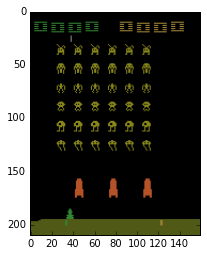

session # 0
 RIGHT(qv = 0.0) -> 0.0 |  RIGHT(qv = 17.0107421875) -> 0.0 |  LEFT(qv = 23.0899906158) -> 0.0 |  LEFT(qv = 41.9223251343) -> 0.0 |  LEFT(qv = 49.2291259766) -> 0.0 |  LEFT(qv = 42.1733016968) -> 0.0 |  LEFT(qv = 42.3626899719) -> 0.0 |  LEFT(qv = 48.4481506348) -> 0.0 |  LEFT(qv = 47.5009040833) -> 0.0 |  LEFT(qv = 44.0708694458) -> 0.0 |  LEFT(qv = 48.0360908508) -> 0.0 |  LEFT(qv = 45.2569274902) -> 0.0 |  LEFT(qv = 43.1937522888) -> 0.0 |  LEFT(qv = 42.2045822144) -> 0.0 |  LEFTFIRE(qv = -28.2102298737) -> 0.0 |  LEFT(qv = 51.2230606079) -> 0.0 |  LEFT(qv = 40.0591087341) -> 0.0 |  LEFT(qv = 44.1582870483) -> 0.0 |  LEFT(qv = 38.7117919922) -> 0.0 |  LEFT(qv = 41.0340957642) -> 0.0 | reached max session length


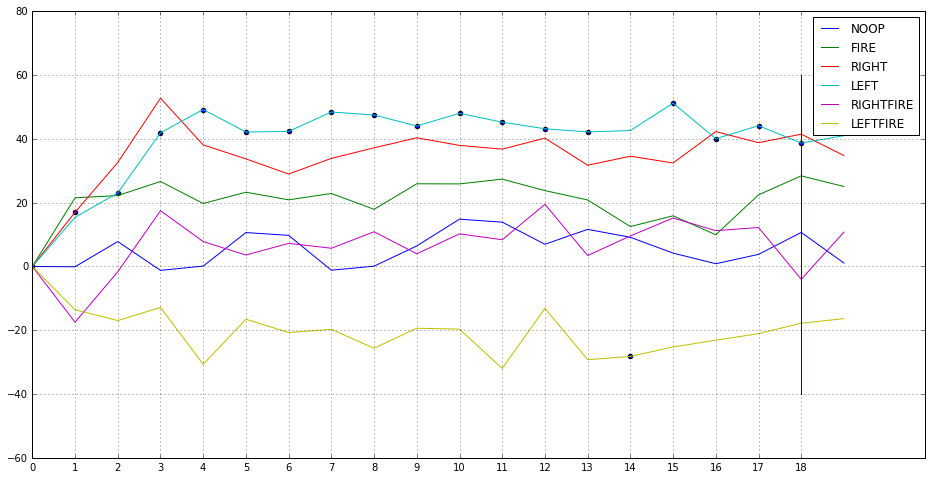

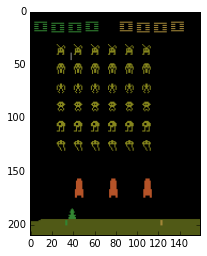

session # 0
 RIGHT(qv = 0.0) -> 0.0 |  RIGHT(qv = 23.0037479401) -> 0.0 |  LEFT(qv = 26.3005104065) -> 0.0 |  LEFT(qv = 43.7905883789) -> 0.0 |  LEFT(qv = 45.8628692627) -> 0.0 |  LEFT(qv = 42.6848297119) -> 0.0 |  LEFT(qv = 40.7595672607) -> 0.0 |  LEFT(qv = 40.3927841187) -> 0.0 |  LEFT(qv = 42.4598464966) -> 0.0 |  LEFT(qv = 40.8744430542) -> 0.0 |  LEFT(qv = 47.4164810181) -> 0.0 |  LEFT(qv = 48.5434188843) -> 0.0 |  LEFT(qv = 38.0057296753) -> 0.0 |  LEFT(qv = 40.4276046753) -> 0.0 |  LEFT(qv = 36.9282684326) -> 0.0 |  LEFT(qv = 50.9586296082) -> 0.0 |  LEFT(qv = 48.5161056519) -> 0.0 |  LEFT(qv = 44.0858459473) -> 0.0 |  LEFT(qv = 43.1350288391) -> 0.0 |  LEFT(qv = 44.1701278687) -> 0.0 | reached max session length


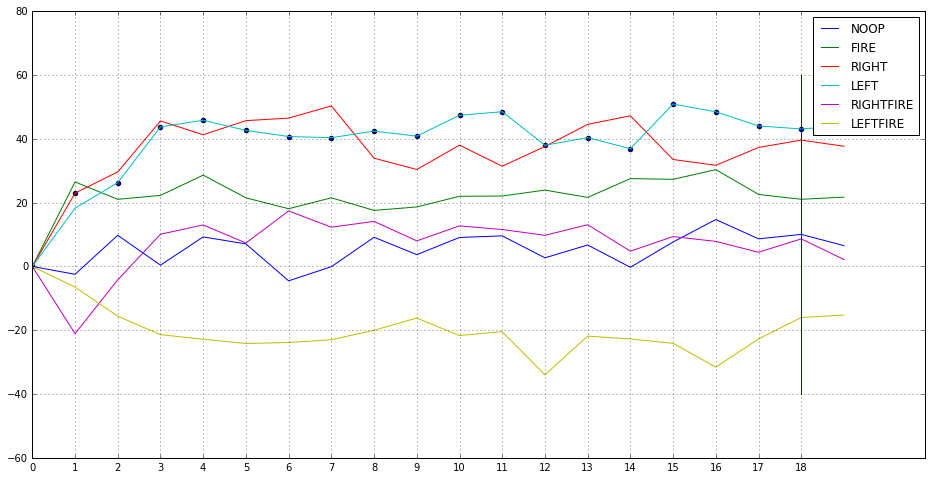

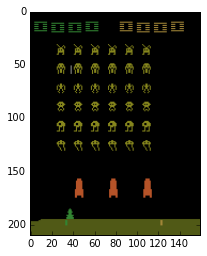

session # 0
 RIGHT(qv = 0.0) -> 0.0 |  RIGHT(qv = 21.4384002686) -> 0.0 |  LEFT(qv = 29.6272277832) -> 0.0 |  LEFT(qv = 49.8308105469) -> 0.0 |  LEFT(qv = 43.7966384888) -> 0.0 |  LEFT(qv = 36.6107406616) -> 0.0 |  LEFT(qv = 47.0649108887) -> 0.0 |  LEFT(qv = 49.0193252563) -> 0.0 |  LEFT(qv = 46.9180259705) -> 0.0 |  LEFT(qv = 50.0836715698) -> 0.0 |  LEFT(qv = 45.735496521) -> 0.0 |  LEFT(qv = 46.5108337402) -> 0.0 |  LEFT(qv = 42.8418807983) -> 0.0 |  LEFT(qv = 46.3344726562) -> 0.0 |  LEFT(qv = 41.3722457886) -> 0.0 |  LEFT(qv = 44.2549743652) -> 0.0 |  LEFT(qv = 38.148853302) -> 0.0 |  LEFT(qv = 41.3182983398) -> 0.0 |  LEFT(qv = 45.9764862061) -> 0.0 |  LEFT(qv = 35.9061813354) -> 0.0 | reached max session length


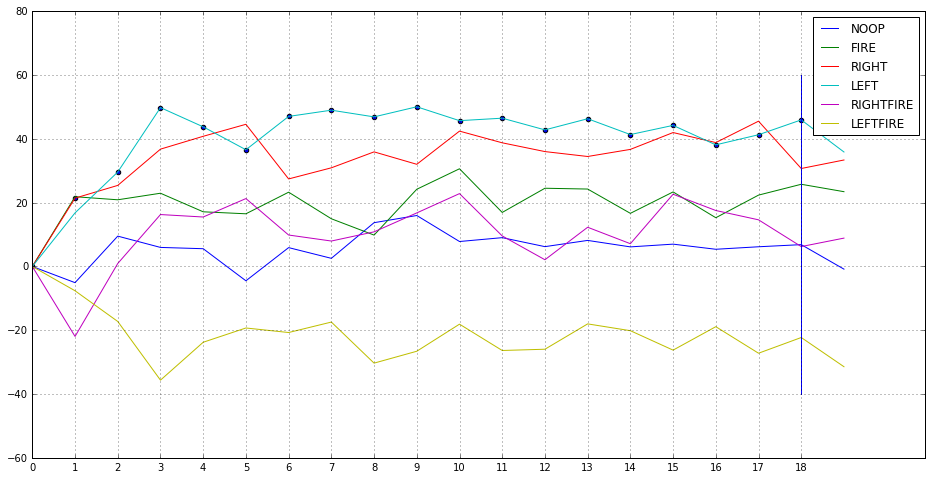

In [28]:
#visualize untrained network performance (which is mostly random)
epsilon.set_value(0.05)
display_sessions(with_plots=True)

# Training loop

In [29]:
#tools for model persistence (in progress now. Requires unique names)
from agentnet.utils.persistence import save,load
import os

In [30]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

epoch 50,loss 14756.77823, epsilon 0.45718, rewards: ( e-greedy 0.05000, greedy 0.30000) 
rec 14756.598 reg 0.181
epoch 100,loss 1766.88725, epsilon 0.41843, rewards: ( e-greedy 0.89500, greedy 0.72000) 
rec 1766.707 reg 0.181
epoch 150,loss 399.98242, epsilon 0.38337, rewards: ( e-greedy 1.05550, greedy 1.09800) 
rec 399.802 reg 0.181
epoch 200,loss 145.09425, epsilon 0.35164, rewards: ( e-greedy 1.34995, greedy 1.33820) 
rec 144.914 reg 0.181
epoch 250,loss 84.36658, epsilon 0.32294, rewards: ( e-greedy 2.31496, greedy 1.45438) 
rec 84.186 reg 0.181
epoch 300,loss 51.92619, epsilon 0.29697, rewards: ( e-greedy 2.28346, greedy 1.45894) 
rec 51.746 reg 0.181
epoch 350,loss 39.24382, epsilon 0.27346, rewards: ( e-greedy 2.40511, greedy 1.56305) 
rec 39.063 reg 0.181
epoch 400,loss 28.19599, epsilon 0.25220, rewards: ( e-greedy 2.56460, greedy 1.75674) 
rec 28.015 reg 0.181
epoch 450,loss 28.45713, epsilon 0.23296, rewards: ( e-greedy 2.40814, greedy 1.98107) 
rec 28.277 reg 0.181
epoch 

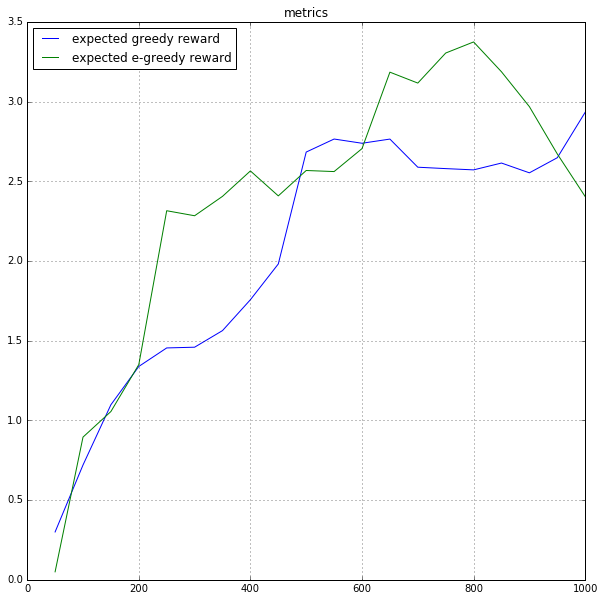

Random session examples


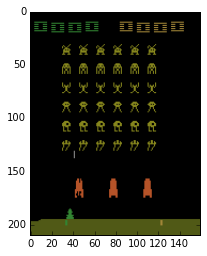

session # 0
 FIRE(qv = 0.614363610744) -> 0.0 |  FIRE(qv = 4.26652574539) -> 0.0 |  FIRE(qv = 3.92261815071) -> 0.0 |  LEFTFIRE(qv = 2.60938763618) -> 0.0 |  FIRE(qv = 3.87693977356) -> 0.0 |  RIGHTFIRE(qv = 3.28446149826) -> 0.0 |  NOOP(qv = 3.70412492752) -> 0.0 |  RIGHTFIRE(qv = 3.27573823929) -> 0.0 |  LEFTFIRE(qv = 3.75775146484) -> 0.0 |  RIGHT(qv = 3.6175339222) -> 0.0 |  RIGHTFIRE(qv = 3.39977502823) -> 0.0 |  LEFTFIRE(qv = 3.69966459274) -> 0.0 |  RIGHT(qv = 3.85742473602) -> 0.0 |  LEFTFIRE(qv = 4.2706785202) -> 0.0 |  LEFTFIRE(qv = 4.00312376022) -> 0.0 |  RIGHT(qv = 3.97419786453) -> 0.0 |  RIGHT(qv = 4.09758663177) -> 0.0 |  FIRE(qv = 4.30565261841) -> 0.0 |  FIRE(qv = 4.33914804459) -> 0.0 |  RIGHTFIRE(qv = 3.67064523697) -> 0.0 | reached max session length


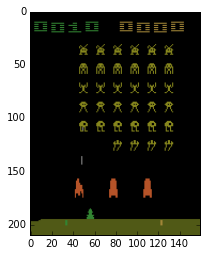

session # 0
 LEFTFIRE(qv = 0.361173689365) -> 0.0 |  FIRE(qv = 4.073802948) -> 0.0 |  LEFT(qv = 3.14041090012) -> 0.0 |  LEFTFIRE(qv = 2.61298680305) -> 0.0 |  FIRE(qv = 2.30561208725) -> 0.0 |  RIGHT(qv = 3.62834000587) -> 0.0 |  LEFTFIRE(qv = 3.17388033867) -> 0.0 |  LEFT(qv = 3.20917677879) -> 0.0 |  RIGHT(qv = 2.33245682716) -> 0.0 |  RIGHT(qv = 3.51445007324) -> 0.0 |  LEFTFIRE(qv = 2.9608206749) -> 0.0 |  LEFTFIRE(qv = 2.65759348869) -> 0.0 |  LEFT(qv = 2.85187602043) -> 0.0 |  LEFT(qv = 2.88378167152) -> 0.0 |  RIGHT(qv = 3.01320004463) -> 0.0 |  RIGHT(qv = 3.87051606178) -> 0.0 |  FIRE(qv = 3.27990794182) -> 0.0 |  LEFTFIRE(qv = 3.39169621468) -> 0.0 |  RIGHT(qv = 3.43239116669) -> 0.0 |  LEFT(qv = 3.70120120049) -> 0.0 | reached max session length


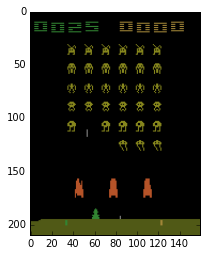

session # 0
 FIRE(qv = 0.61817085743) -> 0.0 |  FIRE(qv = 4.8822312355) -> 0.0 |  FIRE(qv = 4.30406570435) -> 0.0 |  LEFTFIRE(qv = 4.12549829483) -> 0.0 |  FIRE(qv = 3.89670300484) -> 15.0 |  RIGHT(qv = 4.76331043243) -> 0.0 |  FIRE(qv = 4.18061494827) -> 0.0 |  RIGHT(qv = 4.43591213226) -> 0.0 |  LEFTFIRE(qv = 3.8834810257) -> 0.0 |  RIGHT(qv = 5.15734815598) -> 0.0 |  LEFT(qv = 4.40550136566) -> 0.0 |  RIGHT(qv = 5.1805434227) -> 0.0 |  LEFT(qv = 4.87662553787) -> 0.0 |  LEFT(qv = 4.91155576706) -> 0.0 |  LEFT(qv = 4.6276679039) -> 0.0 |  FIRE(qv = 4.69293451309) -> 0.0 |  RIGHT(qv = 4.72147798538) -> 0.0 |  LEFTFIRE(qv = 5.03235769272) -> 0.0 |  RIGHT(qv = 4.82542991638) -> 0.0 |  RIGHT(qv = 4.48987054825) -> 0.0 | reached max session length
epoch 1050,loss 8.89095, epsilon 0.10511, rewards: ( e-greedy 2.71345, greedy 3.18942) 
rec 8.711 reg 0.180
epoch 1100,loss 2.86056, epsilon 0.09986, rewards: ( e-greedy 2.59210, greedy 3.12048) 
rec 2.680 reg 0.180
epoch 1150,loss 3.02140, epsi

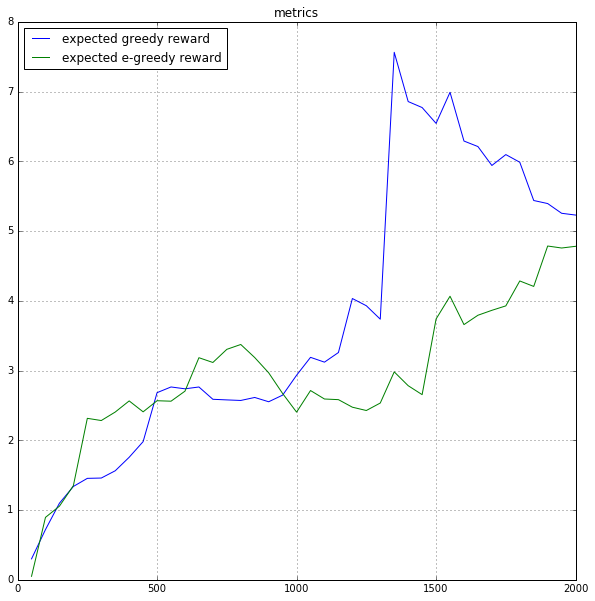

Random session examples


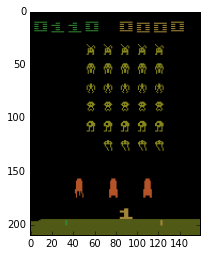

session # 0
 LEFTFIRE(qv = 6.67390108109) -> 0.0 |  NOOP(qv = 4.31972503662) -> 0.0 |  NOOP(qv = 3.61290454865) -> 0.0 |  NOOP(qv = 3.1745197773) -> 0.0 |  NOOP(qv = 2.88600254059) -> 0.0 |  NOOP(qv = 2.70617961884) -> 0.0 |  NOOP(qv = 2.95137858391) -> 0.0 |  NOOP(qv = 2.91194415092) -> 0.0 |  NOOP(qv = 3.17556977272) -> 0.0 |  NOOP(qv = 2.87113142014) -> 0.0 |  NOOP(qv = 2.84833788872) -> 0.0 |  NOOP(qv = 2.70514273643) -> 0.0 |  NOOP(qv = 3.14680671692) -> 0.0 |  NOOP(qv = 2.95577430725) -> 0.0 |  NOOP(qv = 3.64418506622) -> 0.0 |  LEFTFIRE(qv = 3.60150003433) -> 0.0 |  RIGHT(qv = 3.66988062859) -> 0.0 |  RIGHT(qv = 3.28380680084) -> 0.0 |  RIGHT(qv = 3.15618276596) -> 0.0 |  NOOP(qv = 3.88824391365) -> 0.0 | reached max session length


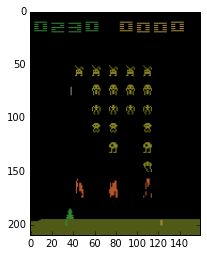

session # 0
 LEFTFIRE(qv = 6.72065830231) -> 0.0 |  LEFTFIRE(qv = 7.3061299324) -> 0.0 |  LEFTFIRE(qv = 5.20032739639) -> 0.0 |  RIGHTFIRE(qv = 3.95512580872) -> 0.0 |  RIGHTFIRE(qv = 3.56001019478) -> 0.0 |  RIGHT(qv = 3.21218776703) -> 0.0 |  LEFTFIRE(qv = 3.87166881561) -> 0.0 |  RIGHTFIRE(qv = 3.84533953667) -> 0.0 |  NOOP(qv = 3.82543444633) -> 0.0 |  NOOP(qv = 3.14839148521) -> 0.0 |  RIGHTFIRE(qv = 3.20347332954) -> 0.0 |  LEFT(qv = 3.6577167511) -> 0.0 |  LEFT(qv = 3.71063494682) -> 0.0 |  LEFT(qv = 4.21602010727) -> 0.0 |  RIGHT(qv = 3.31839108467) -> 0.0 |  LEFT(qv = 3.53252625465) -> 0.0 |  RIGHT(qv = 3.26822400093) -> 0.0 |  RIGHTFIRE(qv = 2.96639823914) -> 0.0 |  RIGHTFIRE(qv = 2.75633072853) -> 0.0 |  RIGHTFIRE(qv = 3.22481942177) -> 0.0 | reached max session length


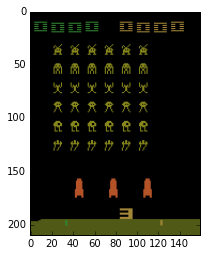

session # 0
 LEFTFIRE(qv = 6.75588655472) -> 0.0 |  RIGHTFIRE(qv = 2.35527014732) -> 0.0 |  NOOP(qv = 1.41986572742) -> 0.0 |  NOOP(qv = 1.27101528645) -> 0.0 |  RIGHT(qv = 1.13361525536) -> 0.0 |  NOOP(qv = 1.49488651752) -> 0.0 |  NOOP(qv = 1.29457938671) -> 0.0 |  NOOP(qv = 1.63805437088) -> 0.0 |  NOOP(qv = 1.22388517857) -> 0.0 |  RIGHT(qv = 1.07502698898) -> 0.0 |  NOOP(qv = 1.60470831394) -> 0.0 |  NOOP(qv = 1.49428117275) -> 0.0 |  NOOP(qv = 1.17560577393) -> 0.0 |  NOOP(qv = 1.33656549454) -> 0.0 |  RIGHT(qv = 1.29670238495) -> 0.0 |  RIGHT(qv = 1.31658267975) -> 0.0 |  NOOP(qv = 1.26157712936) -> 0.0 |  NOOP(qv = 1.56159245968) -> 0.0 |  NOOP(qv = 1.22148001194) -> 0.0 |  RIGHT(qv = 1.48180222511) -> 0.0 | reached max session length
epoch 2050,loss 10.57840, epsilon 0.05746, rewards: ( e-greedy 5.10307, greedy 5.30634) 
rec 10.398 reg 0.180
epoch 2100,loss 7.51989, epsilon 0.05675, rewards: ( e-greedy 5.09277, greedy 4.87570) 
rec 7.340 reg 0.180
epoch 2150,loss 11.19033, eps

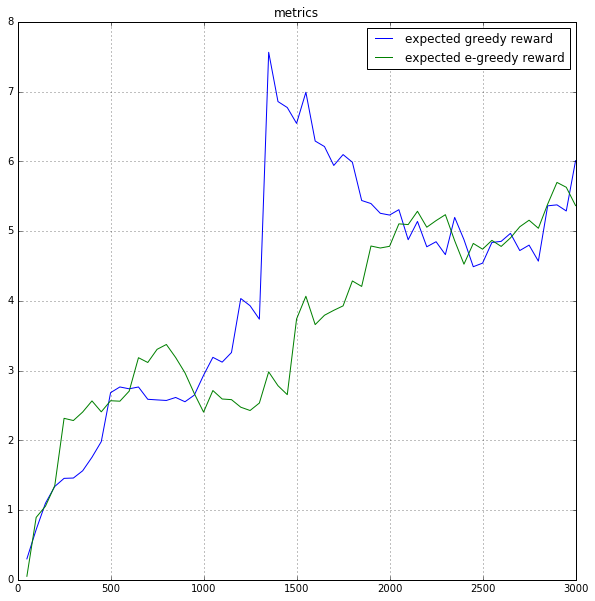

Random session examples


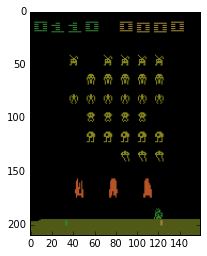

session # 0
 RIGHTFIRE(qv = 6.44283294678) -> 0.0 |  RIGHTFIRE(qv = 9.05430698395) -> 0.0 |  RIGHTFIRE(qv = 10.6445541382) -> 0.0 |  RIGHTFIRE(qv = 11.1711540222) -> 0.0 |  RIGHTFIRE(qv = 11.2989397049) -> 0.0 |  RIGHTFIRE(qv = 11.0744152069) -> 0.0 |  RIGHTFIRE(qv = 11.014875412) -> 0.0 |  RIGHTFIRE(qv = 11.262840271) -> 0.0 |  RIGHTFIRE(qv = 11.0170898438) -> 0.0 |  RIGHTFIRE(qv = 11.0591812134) -> 0.0 |  RIGHTFIRE(qv = 10.7711114883) -> 0.0 |  RIGHTFIRE(qv = 10.7872877121) -> 0.0 |  RIGHTFIRE(qv = 10.9894657135) -> 0.0 |  RIGHTFIRE(qv = 11.0953683853) -> 0.0 | 



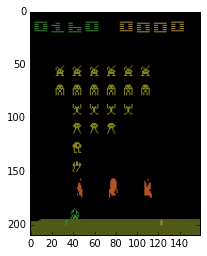

session # 0
 RIGHTFIRE(qv = 6.40927267075) -> 0.0 |  FIRE(qv = 4.32426309586) -> 0.0 |  LEFT(qv = 3.68762230873) -> 0.0 |  LEFT(qv = 3.39671874046) -> 0.0 |  LEFT(qv = 3.04732084274) -> 0.0 |  LEFT(qv = 3.51840925217) -> 0.0 |  LEFT(qv = 3.22041463852) -> 0.0 |  LEFT(qv = 3.28529214859) -> 0.0 |  LEFT(qv = 3.51436829567) -> 0.0 |  LEFT(qv = 3.27509450912) -> 0.0 |  LEFT(qv = 2.98406028748) -> 0.0 |  LEFT(qv = 3.41510725021) -> 0.0 |  LEFT(qv = 3.4228105545) -> 0.0 |  LEFT(qv = 3.2874584198) -> 0.0 |  LEFT(qv = 3.93400764465) -> 0.0 |  LEFT(qv = 2.56570887566) -> 0.0 |  LEFT(qv = 2.23977732658) -> 0.0 |  LEFT(qv = 2.32458806038) -> 0.0 |  LEFT(qv = 2.44885158539) -> 0.0 |  LEFT(qv = 1.85086107254) -> 0.0 | reached max session length


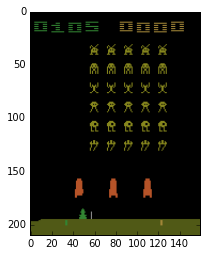

session # 0
 LEFTFIRE(qv = 6.70041942596) -> 0.0 |  RIGHTFIRE(qv = 2.66031432152) -> 0.0 |  RIGHTFIRE(qv = 1.61489999294) -> 0.0 |  RIGHT(qv = 1.14536106586) -> 0.0 |  RIGHTFIRE(qv = 1.82922875881) -> 0.0 |  RIGHT(qv = 1.48054277897) -> 0.0 |  RIGHT(qv = 1.5977063179) -> 0.0 |  RIGHT(qv = 1.1132311821) -> 0.0 |  LEFT(qv = 1.52247846127) -> 0.0 |  LEFT(qv = 1.49036252499) -> 0.0 |  FIRE(qv = 2.00418376923) -> 0.0 |  RIGHTFIRE(qv = 1.69024074078) -> 0.0 |  RIGHTFIRE(qv = 1.36011898518) -> 0.0 |  RIGHTFIRE(qv = 1.62763488293) -> 0.0 |  RIGHTFIRE(qv = 1.58048141003) -> 0.0 |  RIGHT(qv = 1.35118663311) -> 0.0 |  RIGHTFIRE(qv = 2.22935318947) -> 0.0 |  RIGHTFIRE(qv = 1.81264150143) -> 0.0 |  RIGHTFIRE(qv = 1.52317738533) -> 0.0 |  RIGHTFIRE(qv = 2.20134711266) -> 0.0 | reached max session length


In [ ]:
n_epochs = 5000
batch_size= 10

for i in range(n_epochs):    
    
    
    #train
    update_pool(env,ataries,replay_seq_len)
    resolver.rng.seed(i)    
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/500.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%50 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,ataries,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,ataries,replay_seq_len)

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %5000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results

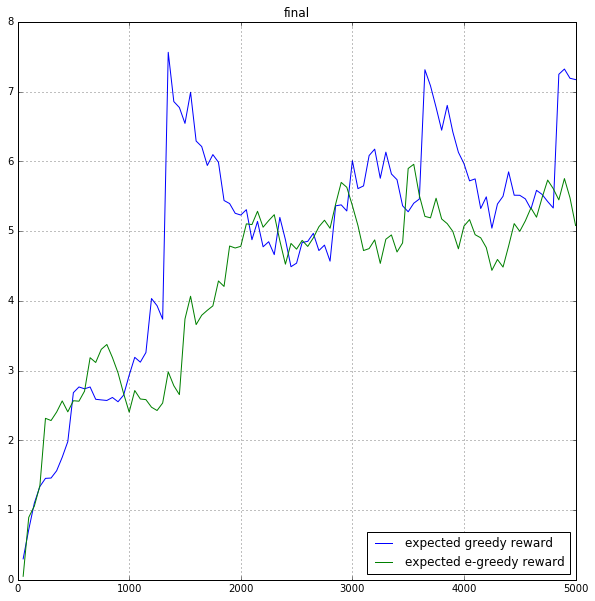

In [33]:
score_log.plot("final")

Random session examples


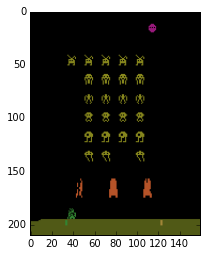

session # 0
 LEFTFIRE(qv = 6.95912075043) -> 0.0 |  LEFTFIRE(qv = 9.14209079742) -> 0.0 |  FIRE(qv = 6.82332038879) -> 0.0 |  FIRE(qv = 5.31659412384) -> 0.0 |  FIRE(qv = 5.92987680435) -> 0.0 |  FIRE(qv = 6.50603485107) -> 0.0 |  RIGHTFIRE(qv = 5.58646774292) -> 0.0 |  FIRE(qv = 6.66331005096) -> 0.0 |  FIRE(qv = 6.77930021286) -> 0.0 |  FIRE(qv = 6.90200662613) -> 0.0 |  FIRE(qv = 6.58044528961) -> 0.0 |  FIRE(qv = 6.09278202057) -> 0.0 |  FIRE(qv = 6.90610933304) -> 0.0 |  FIRE(qv = 6.70829343796) -> 0.0 |  FIRE(qv = 6.48970842361) -> 0.0 |  FIRE(qv = 6.68630218506) -> 0.0 |  FIRE(qv = 6.30649185181) -> 0.0 |  FIRE(qv = 6.27748060226) -> 0.0 |  FIRE(qv = 6.18165063858) -> 0.0 |  FIRE(qv = 6.61669445038) -> 0.0 | reached max session length


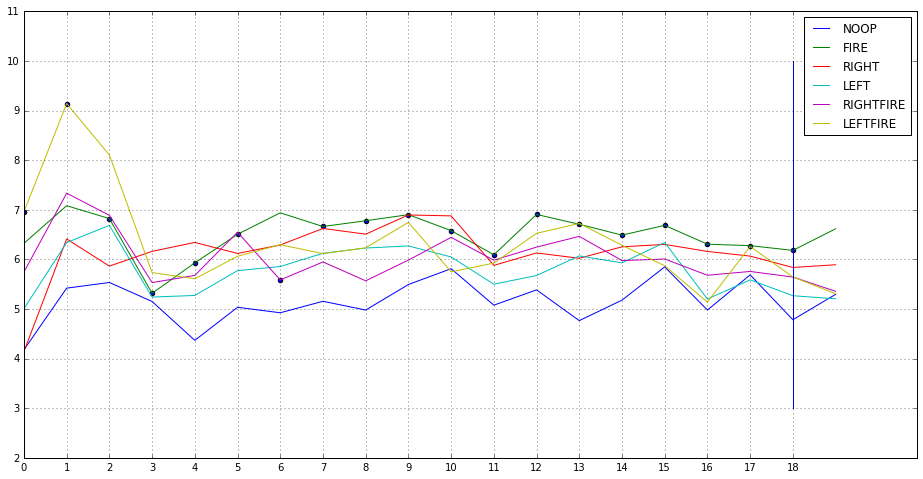

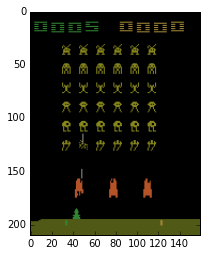

session # 0
 LEFTFIRE(qv = 7.05658912659) -> 0.0 |  LEFTFIRE(qv = 9.75023651123) -> 0.0 |  LEFTFIRE(qv = 9.99103832245) -> 0.0 |  LEFTFIRE(qv = 12.1100463867) -> 0.0 |  LEFTFIRE(qv = 11.1966934204) -> 0.0 |  LEFTFIRE(qv = 12.0566387177) -> 0.0 |  LEFTFIRE(qv = 12.1139783859) -> 0.0 |  LEFTFIRE(qv = 13.0228939056) -> 0.0 |  LEFTFIRE(qv = 14.1997013092) -> 0.0 |  LEFTFIRE(qv = 13.8280878067) -> 0.0 |  LEFTFIRE(qv = 14.7384843826) -> 0.0 |  LEFTFIRE(qv = 12.8463478088) -> 0.0 |  LEFTFIRE(qv = 13.0512752533) -> 0.0 |  LEFTFIRE(qv = 13.5006389618) -> 10.0 |  LEFTFIRE(qv = 12.6017808914) -> 0.0 |  LEFTFIRE(qv = 10.5964288712) -> 0.0 |  LEFTFIRE(qv = 10.1885318756) -> 0.0 |  LEFT(qv = 9.57985210419) -> 0.0 |  LEFTFIRE(qv = 11.5489749908) -> 0.0 |  LEFTFIRE(qv = 12.0056962967) -> 0.0 | reached max session length


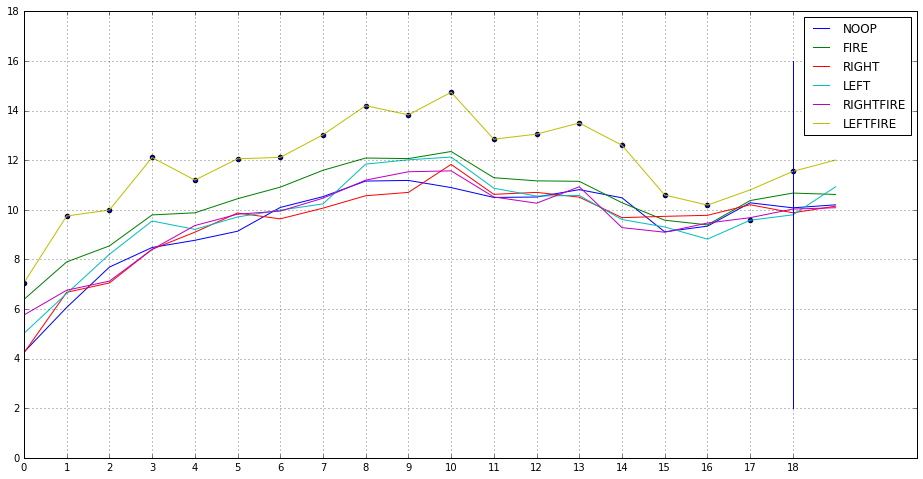

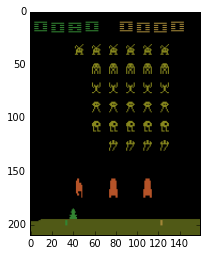

session # 0
 LEFTFIRE(qv = 7.05920696259) -> 0.0 |  FIRE(qv = 3.28568339348) -> 0.0 |  FIRE(qv = 3.12788081169) -> 0.0 |  RIGHT(qv = 2.40238213539) -> 0.0 |  RIGHT(qv = 2.43629312515) -> 0.0 |  RIGHT(qv = 3.82750439644) -> 0.0 |  RIGHT(qv = 4.51629447937) -> 0.0 |  FIRE(qv = 4.14734458923) -> 0.0 |  FIRE(qv = 4.6322350502) -> 0.0 |  NOOP(qv = 4.77289962769) -> 0.0 |  NOOP(qv = 4.85804128647) -> 0.0 |  NOOP(qv = 5.09255886078) -> 0.0 |  RIGHT(qv = 4.34451246262) -> 0.0 |  NOOP(qv = 4.83245754242) -> 0.0 |  FIRE(qv = 4.15323591232) -> 0.0 |  LEFT(qv = 4.48917579651) -> 0.0 |  RIGHTFIRE(qv = 4.64701318741) -> 0.0 |  RIGHTFIRE(qv = 4.37724685669) -> 0.0 |  RIGHTFIRE(qv = 5.07540607452) -> 0.0 |  RIGHTFIRE(qv = 5.94005727768) -> 0.0 | reached max session length


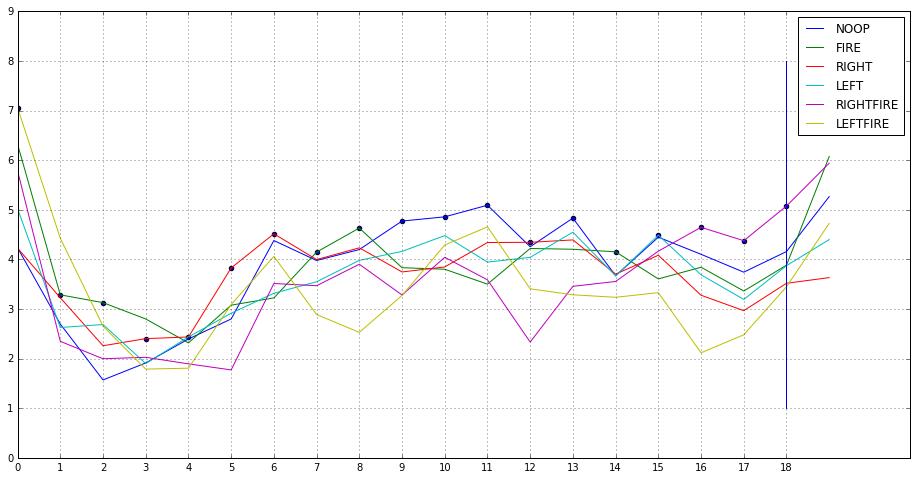

In [34]:
print "Random session examples"
display_sessions(with_plots=True)


# Submission

In [ ]:
epsilon.set_value(0)

In [39]:

save_path = '/tmp/AgentNet-Convolutional-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
#subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(100):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = [np.zeros((1,)+tuple(mem.output_shape[1:]),dtype=floatX) 
                         for mem in agent.state_variables]
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories)
        observation, reward, done, info = subm_env.step(action)
        
        prev_memories = new_memories
        if done:
            print "Episode finished after {} timesteps".format(t+1)
            break
        t+=1

subm_env.monitor.close()

Episode finished after 368 timesteps
Episode finished after 451 timesteps
Episode finished after 835 timesteps
Episode finished after 640 timesteps
Episode finished after 469 timesteps
Episode finished after 892 timesteps
Episode finished after 632 timesteps
Episode finished after 974 timesteps
Episode finished after 388 timesteps
Episode finished after 923 timesteps
Episode finished after 400 timesteps
Episode finished after 461 timesteps
Episode finished after 1362 timesteps
Episode finished after 930 timesteps
Episode finished after 819 timesteps
Episode finished after 1030 timesteps
Episode finished after 491 timesteps
Episode finished after 380 timesteps
Episode finished after 481 timesteps
Episode finished after 536 timesteps
Episode finished after 841 timesteps
Episode finished after 834 timesteps
Episode finished after 915 timesteps
Episode finished after 910 timesteps
Episode finished after 938 timesteps
Episode finished after 679 timesteps
Episode finished after 827 timesteps

[2016-04-30 12:32:52,812] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/AgentNet-Convolutional-AirRaidv0-Recording0')


Episode finished after 395 timesteps


In [ ]:
gym.monitoring._monitors.clear()

In [43]:

gym.upload(save_path,
           
           #this notebook
           writeup="https://gist.github.com/justheuristic/77d603a568ec7fefd43dedc3312cfc36", 
           
           #your api key
           api_key='sk_dRtyWNecT6mIQgExL7mZrw')


[2016-04-30 12:32:59,129] [SpaceInvaders-v0] Uploading 101 episodes of training data
/home/jheuristic/thenv/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/home/jheuristic/thenv/local/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/home/jheuristic/thenv/local/lib/python2.7

<Evaluation evaluation id=eval_yv5uO0fRiS7eNaZGFKacw at 0x443b0850> JSON: {
  "created": 1462019583, 
  "env": "SpaceInvaders-v0", 
  "id": "eval_yv5uO0fRiS7eNaZGFKacw", 
  "object": "evaluation"
}